In [1]:
import logging
import torch
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import cv2
import torchvision.transforms.v2 as transforms
import numpy as np
from pothole.datasets import PotholeDataset
from pothole.training import train
from pothole.models.resnet import get_resnet_model
from torchvision.models import resnet50, ResNet50_Weights
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import random
logging.basicConfig(level=logging.INFO, format='%(name)s: %(message)s')
from tqdm.notebook import tqdm
from sklearn.metrics import top_k_accuracy_score
from torcheval.metrics import BinaryPrecisionRecallCurve
import torch.nn.functional as F
from sklearn.metrics import precision_recall_curve
from torchvision.ops import sigmoid_focal_loss


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
trainset = PotholeDataset(split='train', proposals_path="/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/data/props-0.30-0.40.yml")


In [4]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=None,
    shuffle=True,
    num_workers=3,
)

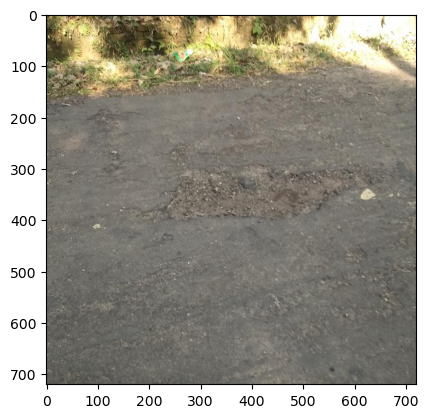

In [139]:
image_path = plt.imread("/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/data/Potholes/annotated-images/img-110.jpg")
plt.imshow(image_path)
plt.savefig("orginalpicturecrop.jpg")

In [86]:
trainset.image_files[0]

PosixPath('/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/data/Potholes/annotated-images/img-110.jpg')

In [112]:
X, y = trainset[0]

In [137]:
y[3]

tensor([1.])

matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


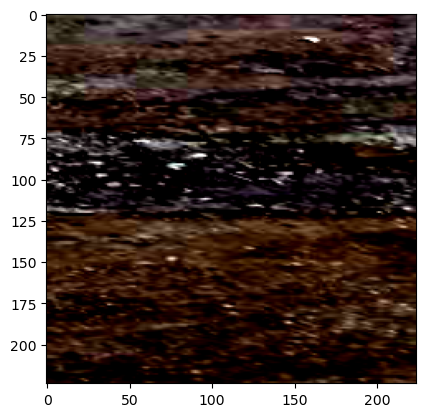

In [138]:
plt.imshow(cv2.cvtColor(trainset[0][0][3].permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB))
plt.savefig("exampleofcroppedpicture.jpg")

In [5]:
valset = PotholeDataset(split='validation', proposals_path="/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/data/props-0.30-0.45_validation.yml")


In [6]:
valsetloader = torch.utils.data.DataLoader(
    valset,
    batch_size=None,
    shuffle=False,
    num_workers=3,
)

In [7]:
testset = PotholeDataset(split='test', proposals_path="/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/data/props-0.30-0.48_test.yml")

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=None,
    shuffle=False,
    num_workers=3,
)

In [163]:
num_epochs = 10
loss_function_1 = nn.BCEWithLogitsLoss()
loss_function_2 = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))

In [165]:
def dropout_resnet_model(network=resnet50, weights=ResNet50_Weights, dropout_prob=0.5): #ResNet50_Weights.IMAGENET1K_V1
    model = network(weights=weights)


    n_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_prob),  # Dropout layer
        nn.Linear(n_features, 1)
    )

    return model
model = dropout_resnet_model().to(device)

/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [167]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=9e-1, weight_decay=5e-4)

In [168]:
losses = []
val_losses = []

current_path = os.getcwd()
log_dir=current_path
best_val_loss = float('inf')

all_outputs = []
all_targets = []
prev_best_model_path = None
model.train()  
for epoch in tqdm(range(num_epochs), unit='epoch'):
    epoch_loss = []
    for X, y in trainloader:
        data, target = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function_2(output, target.float())  
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    losses.append(sum(epoch_loss)/len(epoch_loss))

    val_epoch_loss = []
    model.eval()
    with torch.no_grad():
        for X, y in valsetloader:
            data, target = X.to(device), y.to(device)
            output = model(data)
            probabilities = F.sigmoid(output).cpu().numpy()
            all_outputs.extend(probabilities)
            all_targets.extend(target.cpu().numpy())
            
            val_loss = loss_function_2(output, target.float())
            val_epoch_loss.append(val_loss.item())
            
        average_val_loss = sum(val_epoch_loss) / len(val_epoch_loss)
        val_losses.append(average_val_loss)


        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            model_path = os.path.join(log_dir, 'best_model_{}.pt'.format(epoch))
            torch.save(model.state_dict(), model_path)
            prev_best_val_loss = loss
            print(prev_best_model_path)
            if prev_best_model_path:
                os.remove(prev_best_model_path)
            prev_best_model_path = model_path
    print(f"Average validatoin loss for epoch {epoch}: {average_val_loss}")
    print(f"Average train loss for epoch {epoch}: {losses}")




    


  0%|          | 0/10 [00:00<?, ?epoch/s]

None
Average validatoin loss for epoch 0: 0.6729098418445298
Average train loss for epoch 0: [0.7175941088033798]
/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/nb/best_model_0.pt
Average validatoin loss for epoch 1: 0.6450275221105778
Average train loss for epoch 1: [0.7175941088033798, 0.6802439477322693]
/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/nb/best_model_1.pt
Average validatoin loss for epoch 2: 0.6380057998678901
Average train loss for epoch 2: [0.7175941088033798, 0.6802439477322693, 0.633697561555563]
/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/nb/best_model_2.pt
Average validatoin loss for epoch 3: 0.6177786577380064
Average train loss for epoch 3: [0.7175941088033798, 0.6802439477322693, 0.633697561555563, 0.6196544974258071]
/home/mlut/IDLCV/object_detection/potholes_git/02516_pothole_w3/nb/best_model_3.pt
Average validatoin loss for epoch 4: 0.6068771090922933
Average train loss for epoch 4: [0.7175941088033798, 

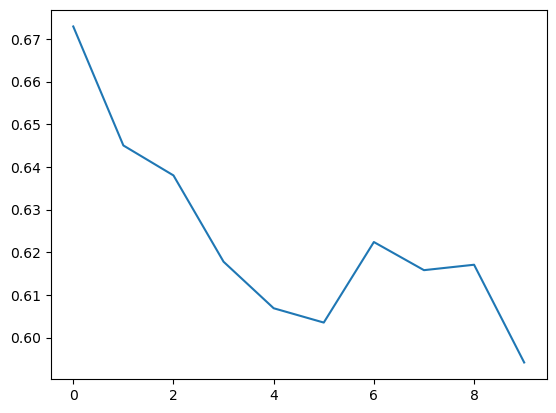

In [169]:
plt.plot(range(num_epochs), val_losses)

matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


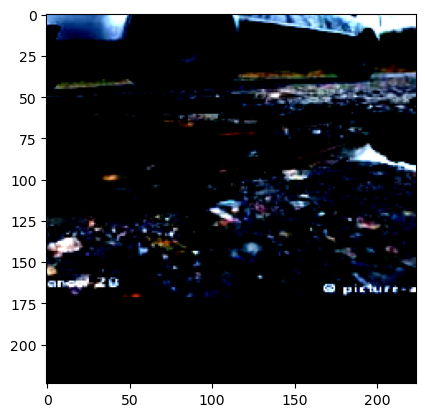

In [34]:
plt.imshow(valset[0][0][0].permute(1,2,0).cpu().numpy())

matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


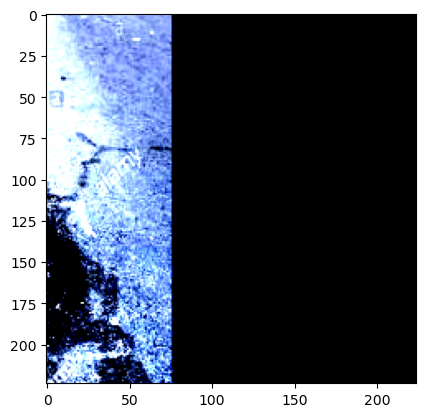

In [37]:
plt.imshow(data[0].permute(1,2,0).cpu().numpy())

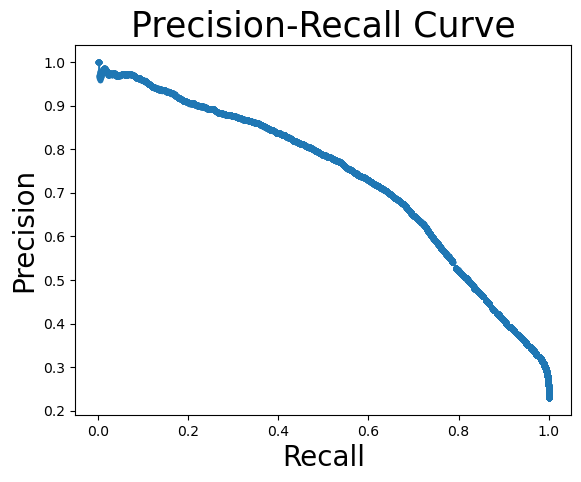

In [170]:
precision, recall, thresholds = precision_recall_curve(all_targets, all_outputs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Precision-Recall Curve', fontsize=25)
plt.show()


In [41]:
all_outputs_test = []
all_targets_test = []
with torch.no_grad():
    for X, y in testloader:
        data, target = X.to(device), y.to(device)
        output = model(data)
        
        all_outputs_test.extend(F.sigmoid(output).cpu().numpy())
        all_targets_test.extend(target.cpu().numpy())

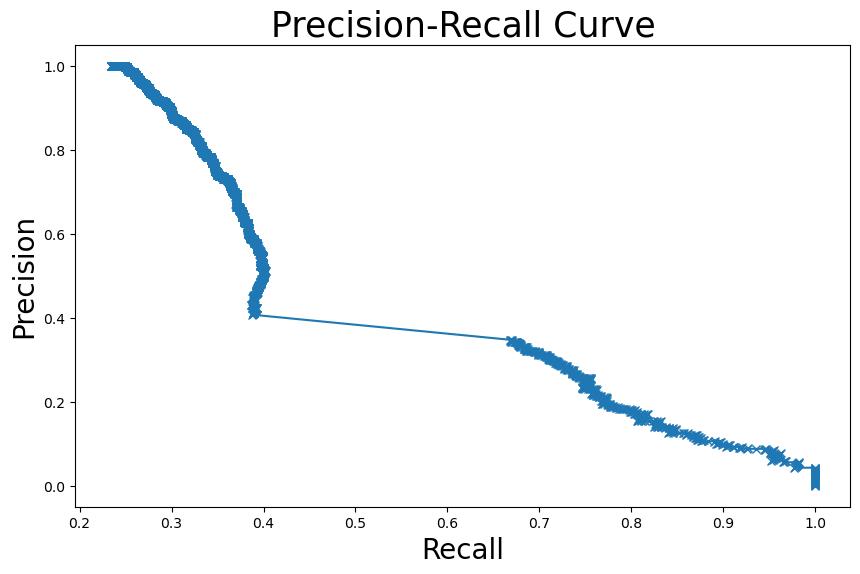

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))

precision_test, recall_test, thresholds = precision_recall_curve(all_targets_test, all_outputs_test)
plt.plot(precision_test, recall_test, marker='x', label='Test')

plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Precision-Recall Curve', fontsize=25)
plt.show()

plt.savefig("precision_recall_plot.png")  # Save the plot as a file


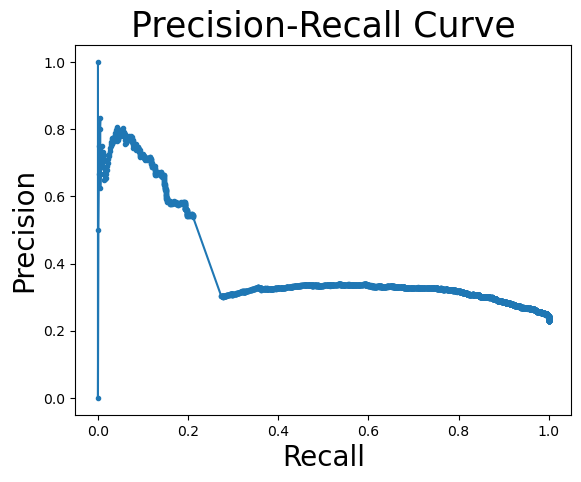

<Figure size 640x480 with 0 Axes>

In [ ]:
precision, recall, thresholds = precision_recall_curve(all_targets, all_outputs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Precision-Recall Curve (test)', fontsize=25)
plt.show()
plt.savefig("precisoinrecallplotvalidation")

In [ ]:
trddain(model=model, opt= optimizer, lossfunc=loss_function, train_loader=trainloader, device=device, epochs = num_epochs)

NameError: name 'trddain' is not defined